## Command Line Arguments

conda create -n hifive1 hifive python=2 matplotlib bedtools pyBigWig jupyter seaborn

conda activate hifive1



Getting and Loading Data:

tar xzf 3DGenomeData.tar.gz

hifive fends mm9.hdf5 --binned 100000 -L genome/mm9.len

hifive hic-data -X data/WT_100kb/raw_\*.mat mm9.hdf5 hic_data.txt

hifive hic-project -f 25 -n 25 -j 100000 hic_data.txt normalized_hic_expression_1.txt

hifive hic-normalize express normalized_hic_expression_1.txt


--------------------------------------------------------


Compartment Analysis Arguments:

grep - hic_comp.bed > comp_b.bed

grep -v - hic_comp.bed > comp_a.bed

bedtools intersect -a data/WT_fpkm.bed -b comp_a.bed -wb >a_compartment_genes.bed

bedtools intersect -a data/WT_fpkm.bed -b comp_b.bed -wb >b_compartment_genes.bed





## Working with the HiC data

In [18]:

#!/usr/bin/env python2
import hifive
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from __future__ import division


Finding fend full array for chr13:1000000-120250001... Done


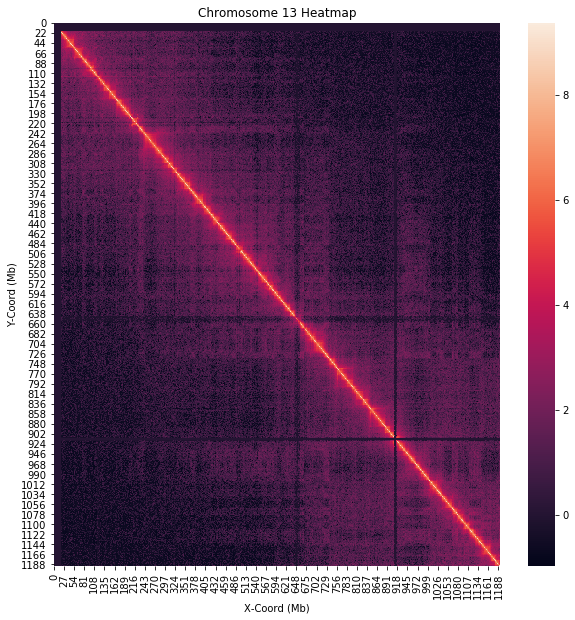

In [26]:
hic=hifive.HiC("normalized_hic_expression_1.txt",'r')
chr13=hic.cis_heatmap('chr13',1000000,datatype='fend',arraytype='full',diagonalincluded=True)
enrichment=(chr13[:,:,0]+1)/(chr13[:,:,1]+1)
log_enrichment=np.log(enrichment)
fig,ax=plt.subplots(figsize=(10,10))
ax.set_title("Chromosome 13 Heatmap")
ax=sns.heatmap(log_enrichment)
ax.set_xlabel("X-Coord (Mb)")
ax.set_ylabel("Y-Coord (Mb)")
plt.savefig("ch13_heatmap.png")

## Compartment analysis

In [3]:
Comp = hifive.hic_domains.Compartment(hic, 100000, chroms=['chr13'], out_fname='tmp.hdf5')
Comp.write_eigen_scores('hic_comp.bed')

Casting complex values to real discards the imaginary part


In [4]:
X = Comp.positions['chr13']
Y = Comp.eigenv['chr13']

## Plotting Compartment Scores

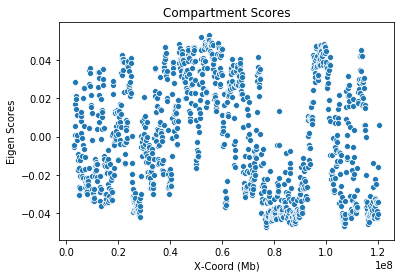

In [54]:
X_start=[x[0] for x in X]
fig,ax=plt.subplots()
sns.scatterplot(X_start,Y)
ax.set_title("Compartment Scores")
ax.set_xlabel("X-Coord (Mb)")
ax.set_ylabel("Eigen Scores")
plt.savefig("Compartment_scores.png")

## Generating Gene Dictionary

In [20]:
genes = open('data/WT_fpkm.bed')
gene_dict = {}
for line in genes:
    a = line.split()
    ##gene_dict[a[3]] = [int(a[2])-int(a[1]), float(a[4][:-1])]
    gene_dict[a[3]]=[int(a[2])-int(a[1]),float(a[4][:-1]),int(a[1]),int(a[2])]

In [27]:
gene_dict

In [22]:
compa=open('a_compartment_genes.bed')
compartment_a_genes=[]
a_dict={}
for line in compa:
    a=line.split('\t')
    gene=a[3]
    start=int(a[1])
    end=int(a[2])
    if gene in a_dict:
        a_dict[gene]+=end-start
    else:
        a_dict[gene]=end-start
for gene in a_dict:
    if gene in gene_dict:
        comp=a_dict[gene]
        size=comp/(gene_dict[gene][0])
        if size>0.5:
            compartment_a_genes.append([gene,gene_dict[gene][1]])

In [23]:
compb=open('b_compartment_genes.bed')
compartment_b_genes=[]
b_dict={}
for line in compb:
    b=line.split('\t')
    gene=b[3]
    start=int(b[1])
    end=int(b[2])
    if gene in b_dict:
        b_dict[gene]+=end-start
    else:
        b_dict[gene]=end-start
for gene in b_dict:
    if gene in gene_dict:
        comp=b_dict[gene]
        size=comp/(gene_dict[gene][0])
        if size>0.5:
            compartment_b_genes.append([gene,gene_dict[gene][1]])

## Plotting Violin Plot

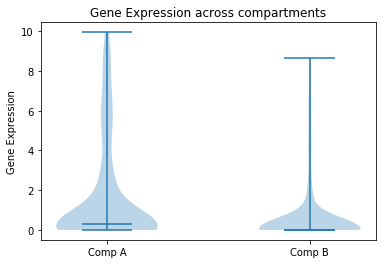

In [24]:
a_data = []
b_data = []

for c in compartment_a_genes:
    if c[1]<10:
        a_data.append(c[1])
    
for d in compartment_b_genes:
    if d[1]<10:
        b_data.append(d[1])

fig, ax = plt.subplots()
ax.violinplot(dataset=[a_data, b_data],showmedians=True)
ax.set_xticks([1,2])
ax.set_xticklabels(["Comp A","Comp B"])
ax.set_ylabel("Gene Expression")
ax.set_title("Gene Expression across compartments")
plt.savefig("violinplot.png")

## Expression vs. Repression Scatterplots

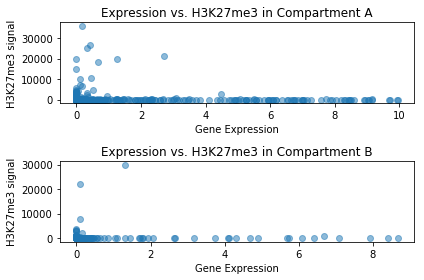

In [53]:
import pyBigWig
bw = pyBigWig.open('data/WT_H3K27me3.bw')
a_h3k27 = []
a_exp = []


for a in compartment_a_genes:
    
    gene = a[0]
    start = gene_dict[gene][2]
    end = gene_dict[gene][3]
    gene_expression = gene_dict[gene][1]
    if gene_expression < 10:
        h3_val = bw.stats('chr13', start, end, type = 'sum')
        
        if h3_val is None:
            h3_val = 0
        
        a_h3k27 += h3_val
        a_exp.append(gene_expression)
        
b_h3k27 = []
b_exp = []
for b in compartment_b_genes:
    
    gene = b[0]
    start = gene_dict[gene][2]
    end = gene_dict[gene][3]
    gene_expression = gene_dict[gene][1]
    if gene_expression<10:
        h3_val = bw.stats('chr13', start, end, type = 'sum')
        
        if h3_val is None:
            h3_val = 0
            
        b_h3k27 += h3_val
        b_exp.append(gene_expression)

fig = plt.figure()

#fig, (ax1,ax2) = plt.subplots(1,2)
ax1 = fig.add_subplot(2,1,1)
ax1.scatter(a_exp, a_h3k27, alpha = 0.5)
ax1.set_title("Expression vs. H3K27me3 in Compartment A")
ax1.set_xlabel('Gene Expression')
ax1.set_ylabel('H3K27me3 signal')

#plt.savefig('A Compartment H3K27me3')

#fig, ax = plt.subplots()
ax2 = fig.add_subplot(2,1,2)
ax2.scatter(b_exp, b_h3k27, alpha = 0.5)
ax2.set_title("Expression vs. H3K27me3 in Compartment B")
ax2.set_xlabel('Gene Expression')
ax2.set_ylabel('H3K27me3 signal')

#plt.savefig('B Compartment H3K27me3')
plt.tight_layout()
plt.savefig('Compartment H3K27me3 Scatterplots')
